In [31]:
#load libraries
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, os
from glob import glob
#Import scikit-learn dataset library
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, plot_roc_curve
from random import shuffle
#classifier:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

In [56]:
#specify the training data
PATH_train = "/Users/leeo/Desktop/卡罗林斯卡/KI_2yr/7.master_thesis/1.data/15.feature_label_intact_20min/label_fe/combine_fe/training_data_undersample_binary.csv"
#specify the testing data
PATH_test = "/Users/leeo/Desktop/卡罗林斯卡/KI_2yr/7.master_thesis/1.data/16.more_feature_label_5min/combine_fe/testing_data_binary.csv"

df = pd.read_csv(PATH_train, sep=",", header=0,
                       parse_dates=[0], index_col=0)
#add coefficient of variance
df["cv"] = df["std"]/df["mean"]
df["cv.1"] = df["std.1"]/df["mean.1"]
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]

# initial Features
X=df.loc[:,['cv', 'cv.1', 'amplitude', 'amplitude.1', 'max_slope', 'max_slope.1','mean', 'mean.1',
            'maximum', 'maximum.1', 'median', 'median.1','minimum', 'minimum.1', 'skew', 'skew.1', 'std', 'std.1']]
y=df[df.columns[-2]]  # Labels

# GridSearchCV

In [57]:
def get_gridsearch_plot(xlabel="param_str", xmin=0,xmax=10, ymin=0, ymax=1.05):
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel(xlabel)
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+xlabel].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'b', "r"]):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.4f" % best_score,
                    (X_axis[best_index], best_score + 0.005))
        print("The best {} is {:.4f} with parameter {}={};".format(scorer, best_score, xlabel,X_axis[best_index]))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

The best model with F1_score: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=202,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
The best AUC is 0.6817 with parameter min_samples_split=152.0;
The best Accuracy is 0.6939 with parameter min_samples_split=132.0;
The best F1_score is 0.4530 with parameter min_samples_split=202.0;


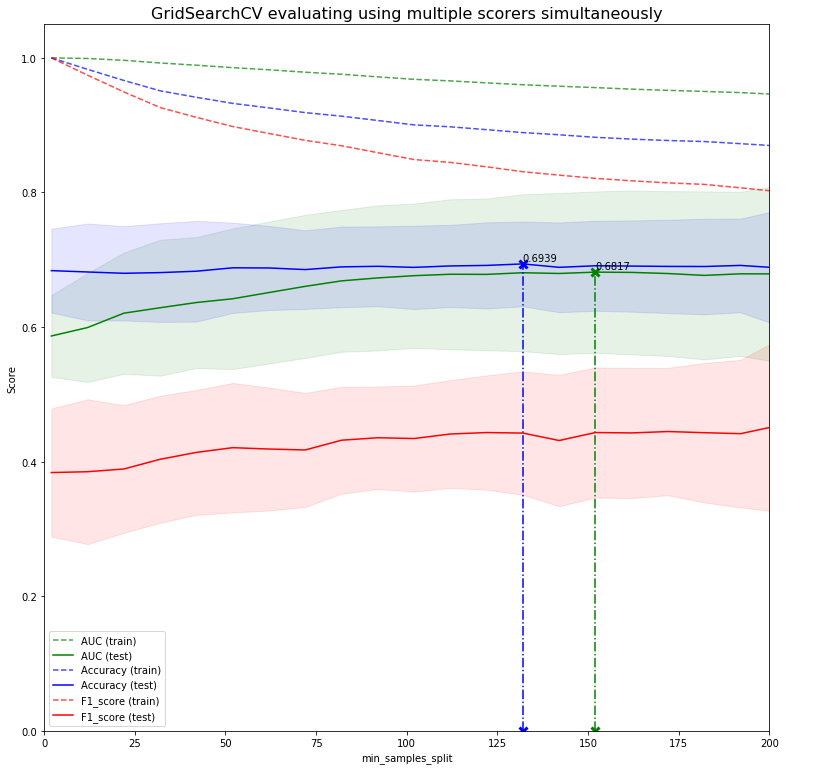

In [58]:
#decision tree
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), "F1_score": make_scorer(f1_score)}
param={'min_samples_split': range(2, 203, 10)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param,
                  scoring=scoring, refit='F1_score', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_
print("The best model with F1_score: \n",gs.best_estimator_)
get_gridsearch_plot(list(param.keys())[0], xmax=200)

The best model with F1_score: 
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
The best AUC is 0.7339 with parameter n_estimators=100.0;
The best Accuracy is 0.6986 with parameter n_estimators=50.0;
The best F1_score is 0.4021 with parameter n_estimators=1.0;


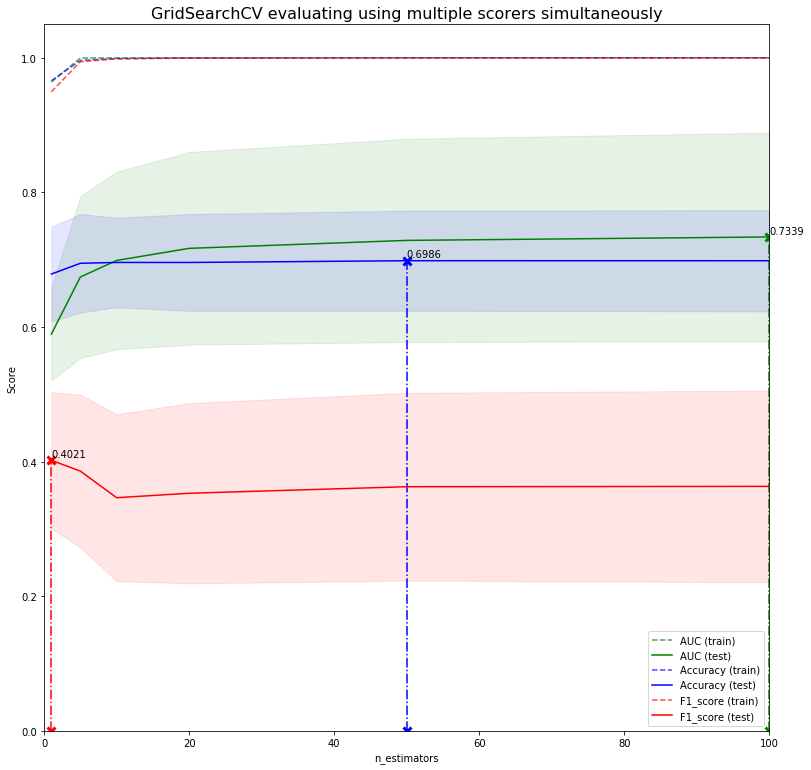

In [59]:
#random forest
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), "F1_score": make_scorer(f1_score)}
param={'n_estimators':[1, 5, 10, 20, 50, 100]}
gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid=param,
                  scoring=scoring, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_
#plot the result
print("The best model with F1_score: \n",gs.best_estimator_)
get_gridsearch_plot(list(param.keys())[0], xmax=100)

The best model with F1_score: 
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
The best AUC is 0.7168 with parameter C=10.0;
The best Accuracy is 0.7282 with parameter C=0.1;
The best F1_score is 0.4740 with parameter C=10.0;


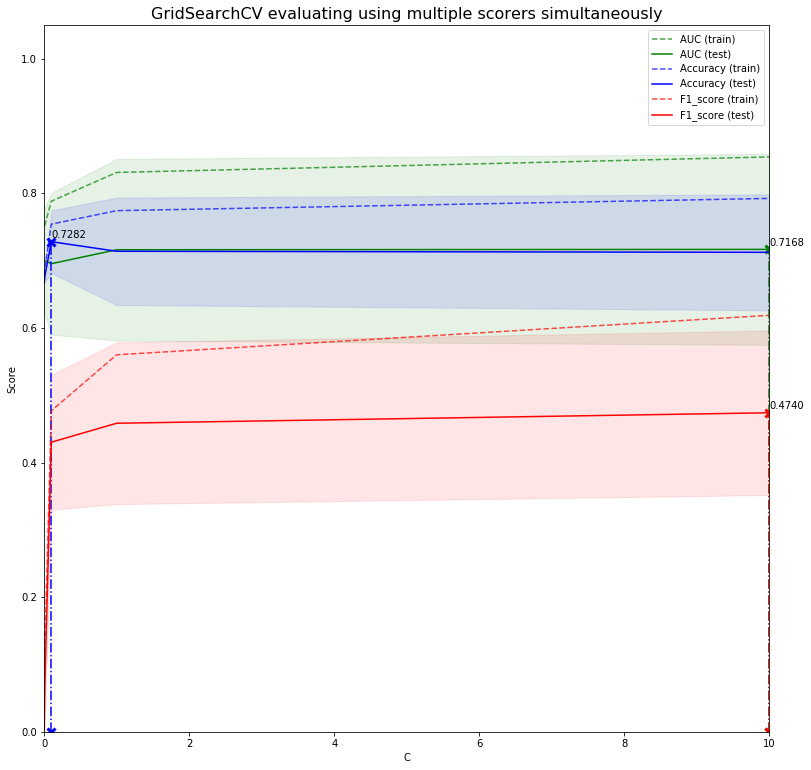

In [60]:
#support vector machine
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), "F1_score": make_scorer(f1_score)}
param={'C': [0.001, 0.01, 0.1, 1, 10]}#gammas = [0.001, 0.01, 0.1, 1]
gs = GridSearchCV(SVC(kernel='rbf'),
                  param_grid=param,
                  scoring=scoring, refit='F1_score', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_
print("The best model with F1_score: \n",gs.best_estimator_)
get_gridsearch_plot(list(param.keys())[0], xmax=10)

The best model with F1_score: 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
The best AUC is 0.7241 with parameter max_depth=19.0;
The best Accuracy is 0.7131 with parameter max_depth=3.0;
The best F1_score is 0.4834 with parameter max_depth=3.0;


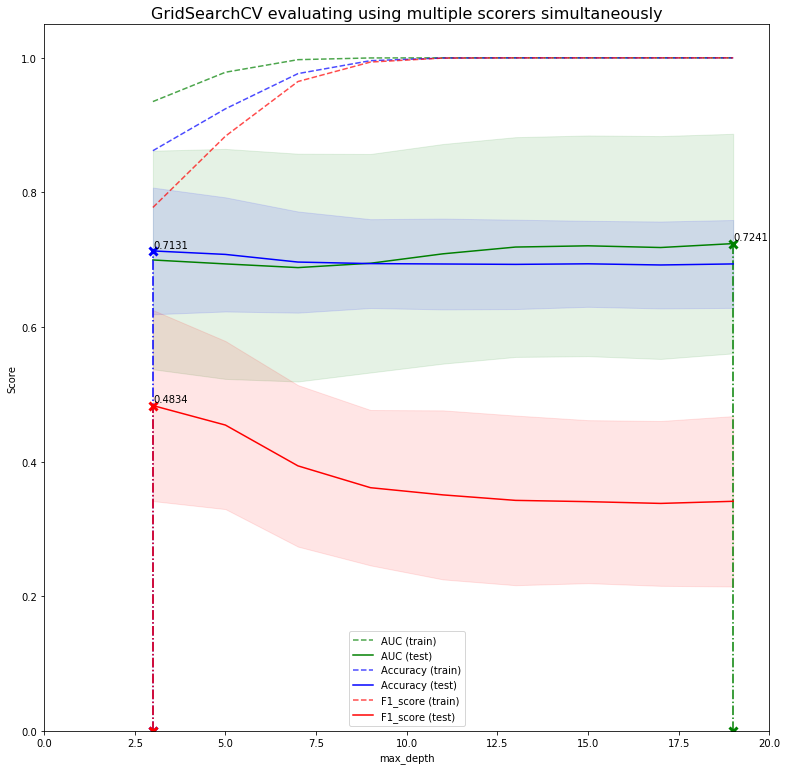

In [61]:
#XGBoost
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), "F1_score": make_scorer(f1_score)}
param={'max_depth':range(3,20,2)}
gs = GridSearchCV(xgb.XGBClassifier(),
                  param_grid=param,
                  scoring=scoring, refit='F1_score', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_
print("The best model with F1_score: \n",gs.best_estimator_)
get_gridsearch_plot(list(param.keys())[0], xmax=20)

/anaconda3/envs/p3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/p3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


The best model with F1_score: 
 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
The best AUC is 0.6779 with parameter alpha=0.0001;
The best Accuracy is 0.7023 with parameter alpha=0.01;
The best F1_score is 0.5274 with parameter alpha=0.0001;


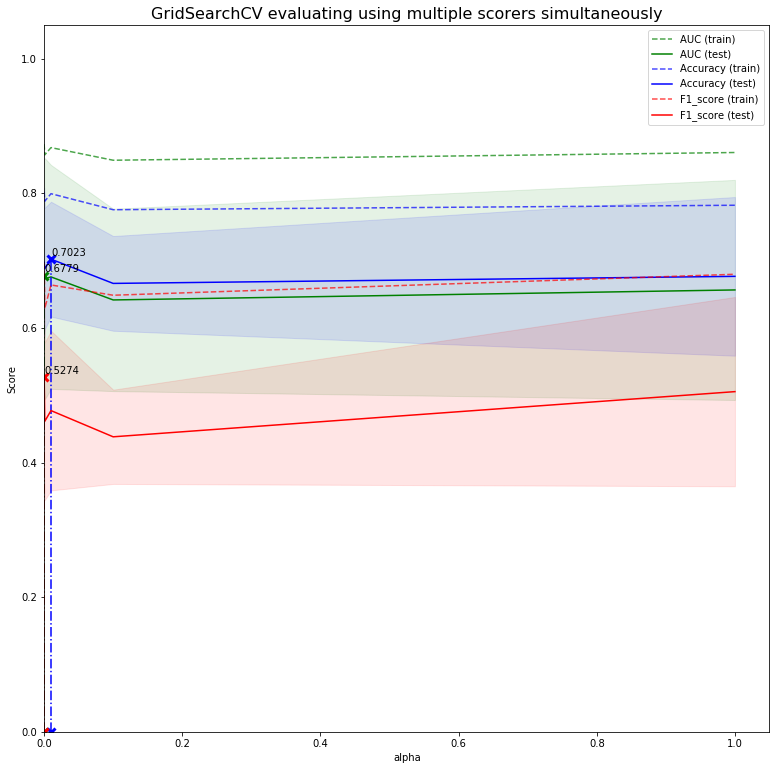

In [62]:
#Multi-Layer Perceptron
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), "F1_score": make_scorer(f1_score)}
param={'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}
gs = GridSearchCV(MLPClassifier(solver='sgd', activation="relu"),
                  param_grid=param,
                  scoring=scoring, refit='F1_score', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_
print("The best model with F1_score: \n",gs.best_estimator_)
get_gridsearch_plot(list(param.keys())[0], xmax=1.05)

# Performance metrics

In [454]:
confusion_matrix = []
accuracy = []
classification_report = []
clf=RandomForestClassifier(n_estimators=20) //move in to for-loop
cv = KFold(n_splits=5, random_state=42, shuffle=True)
#5-fold cv:
for train_index, test_index in cv.split(X):
    #print("Train Index: ", train_index)
    #print("Test Index: ", test_index, "\n")

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)//X_train >> sub_train error
    
    confusion_matrix.append(metrics.confusion_matrix(y_test, y_pred))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    classification_report.append(metrics.classification_report(y_test, y_pred))
print("5-fold cross validation has finished, plz move on to related metrics.")

5-fold cross validation has finished, plz move on to related metrics.


# Model performance for internal evaluation

In [429]:
print("The average accuracy is",np.mean(accuracy),"\n")
print("The confusion matrix are \n",confusion_matrix,"\n")

classification_report_df =[]
for i in classification_report:
    class0 = i.split("\n")[2].split(" ")
    class1 = i.split("\n")[3].split(" ")
    class2 = i.split("\n")[4].split(" ")

    cm=[[float(class0[9]),float(class0[16]),float(class0[22]),float(class0[28]),int(class0[-1])],
        [float(class1[9]),float(class1[16]),float(class1[22]),float(class1[28]),int(class1[-1])],
        [float(class2[9]),float(class2[16]),float(class2[22]),float(class2[28]),int(class2[-1])]]
    classification_report_df.append(pd.DataFrame(cm,columns=["class","precision","recall","f1-score",'support']))
    
precision_sum  = [0, 0, 0]
recall_sum = [0, 0, 0]
f1_score_sum = [0, 0, 0]
support_sum = [0, 0, 0]
for i in classification_report_df:
    
    precision_sum = i["precision"] + precision_sum
    recall_sum = i["recall"] + recall_sum
    f1_score_sum = i["f1-score"] + f1_score_sum
    support_sum = i["support"] + support_sum
print("The average metrics are:\n",
      pd.DataFrame([precision_sum/5,recall_sum/5,f1_score_sum/5,support_sum/5]).transpose())

The average accuracy is 0.8481788755794634 

The confusion matrix are 
 [array([[1283,   94],
       [ 227,  471]]), array([[1296,  115],
       [ 191,  473]]), array([[1294,   95],
       [ 223,  463]]), array([[1261,  100],
       [ 231,  483]]), array([[1288,   90],
       [ 209,  487]])] 



IndexError: list index out of range

# Model performance for External evaluation

In [491]:
#External evaluation
dftest = pd.read_csv(PATH_test, sep=",", header=0,
                       parse_dates=[0], index_col=0)

#add coefficient of variance
dftest["cv"] = dftest["std"]/dftest["mean"]
dftest["cv.1"] = dftest["std.1"]/dftest["mean.1"]
cols = dftest.columns.tolist()
cols = cols[-2:] + cols[:-2]
dftest = dftest[cols]

X_test_ex=dftest.loc[:,['cv', 'cv.1', 'amplitude', 'amplitude.1', 'max_slope', 'max_slope.1','mean', 'mean.1',
            'maximum', 'maximum.1', 'median', 'median.1','minimum', 'minimum.1', 'skew', 'skew.1', 'std', 'std.1']]
y_test_ex=dftest[dftest.columns[-2]]  # Labels

#train with entire traning set
clf.fit(X,y)
y_pred_ex=clf.predict(X_test_ex)

# Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test_ex, y_pred_ex))
print("Accuracy",metrics.accuracy_score(y_test_ex, y_pred_ex))
print("Classification_report:\n",metrics.classification_report(y_test_ex, y_pred_ex))

Confusion matrix:
 [[22339  4811]
 [ 1871  2419]]
Accuracy 0.7874681933842239
Classification_report:
               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     27150
         1.0       0.33      0.56      0.42      4290

    accuracy                           0.79     31440
   macro avg       0.63      0.69      0.64     31440
weighted avg       0.84      0.79      0.81     31440



# Binary problem - internal validation

In [456]:
#Internal
print("The average accuracy is",np.mean(accuracy),"\n")
print("The confusion matrix are \n",confusion_matrix,"\n")

classification_report_df =[]
for i in classification_report:
    class0 = i.split("\n")[2].split(" ")
    class1 = i.split("\n")[3].split(" ")

    cm=[[float(class0[9]),float(class0[16]),float(class0[22]),float(class0[28]),int(class0[-1])],
        [float(class1[9]),float(class1[16]),float(class1[22]),float(class1[28]),int(class1[-1])]]
    classification_report_df.append(pd.DataFrame(cm,columns=["class","precision","recall","f1-score",'support']))
    
precision_sum  = [0, 0]
recall_sum = [0, 0]
f1_score_sum = [0, 0]
support_sum = [0, 0]
for i in classification_report_df:
    
    precision_sum = i["precision"] + precision_sum
    recall_sum = i["recall"] + recall_sum
    f1_score_sum = i["f1-score"] + f1_score_sum
    support_sum = i["support"] + support_sum
print("The average metrics are:\n",
      pd.DataFrame([precision_sum/5,recall_sum/5,f1_score_sum/5,support_sum/5]).transpose())

The average accuracy is 0.8554343362277754 

The confusion matrix are 
 [array([[3839,  304],
       [ 620, 1441]]), array([[3801,  295],
       [ 617, 1491]]), array([[3876,  313],
       [ 569, 1445]]), array([[3846,  291],
       [ 580, 1486]]), array([[3784,  329],
       [ 566, 1524]])] 

The average metrics are:
    precision  recall  f1-score  support
0      0.866   0.928     0.894   4135.6
1      0.828   0.716     0.768   2067.8


# ROC curve

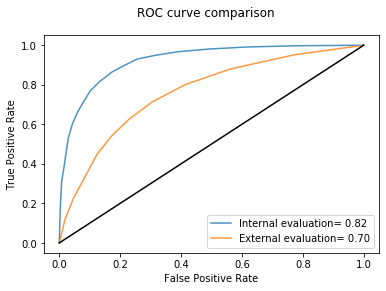

In [465]:
#internal roc curve //train + validate + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
clf_train=RandomForestClassifier(n_estimators=20) #validation
clf_train.fit(X_train,y_train)
y_pred=clf_train.predict(X_test) 

#external roc curve
clf_validate = RandomForestClassifier(n_estimators=10, random_state=42) #test
clf_validate.fit(X, y)

#plot the roc
ax = plt.gca()
in_auc = roc_auc_score(y_test, y_pred)
ex_auc = roc_auc_score(y_test_ex, y_pred_ex)
roc_disp1 = plot_roc_curve(clf_train, X_test, y_test, ax=ax, alpha=0.8, label = 'Internal evaluation= %0.2f' % in_auc)
roc_disp2 = plot_roc_curve(clf_validate, X_test_ex, y_test_ex, ax=ax, alpha=0.8, label = 'External evaluation= %0.2f' % ex_auc)

plt.plot([0,1],[0,1],'-k')
roc_disp2.figure_.suptitle("ROC curve comparison")
plt.show()

# Learning curve

In [488]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

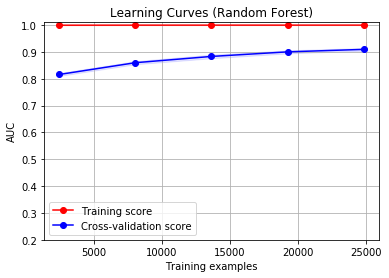

In [468]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = clf_validate.fit(X, y)
plot_learning_curve(estimator, title, X, y, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [483]:
train_sizes = [1000,4000,7000,10000,13000,16000,19000,22000,24813]


train_sizes, train_scores, validation_scores = learning_curve(estimator = clf_validate.fit(X, y),
                                                              X=X,y=y, train_sizes = train_sizes, cv = 5,
                                                              scoring = 'neg_mean_squared_error')
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis =1  )
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Training scores:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.00285714 -0.         -0.         -0.        ]
 [-0.0048     -0.0043     -0.0037     -0.         -0.        ]
 [-0.00530769 -0.00530769 -0.00438462 -0.00338462 -0.00338462]
 [-0.0058125  -0.00525    -0.0043125  -0.0046875  -0.003875  ]
 [-0.00578947 -0.00573684 -0.00531579 -0.00657895 -0.00531579]
 [-0.00645455 -0.00613636 -0.00663636 -0.00622727 -0.00618182]
 [-0.00656914 -0.00648853 -0.00733486 -0.00701245 -0.00584371]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.33333333 -0.33333333 -0.33322586 -0.33338707 -0.33338707]
 [-0.33333333 -0.33333333 -0.33322586 -0.33338707 -0.33338707]
 [-0.33333333 -0.29851709 -0.33322586 -0.33338707 -0.33338707]
 [-0.29142489 -0.28175371 -0.22876028 -0.33338707 -0.33338707]
 [-0.27095422 -0.2912637  -0.23408028 -0.33935193 -0.33677253]
 [-

(0, 0.4)

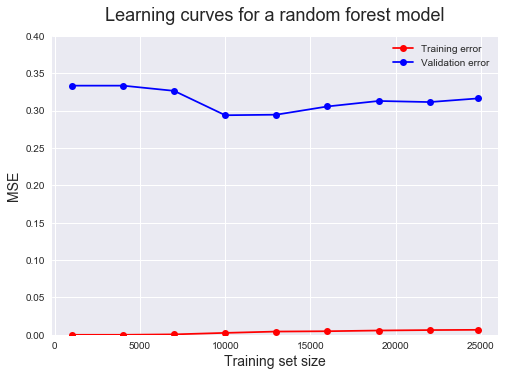

In [487]:

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean,'o-', color="r", label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, 'o-', color="b", label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a random forest model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,0.4)

#  Feature importance

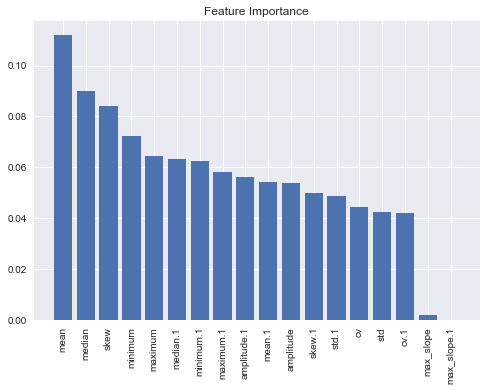

In [485]:
# Calculate feature importances
importances = clf.fit(X,y).feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

# Effect of different parameters

In [493]:
Cs = [5, 10, 15, 20, 30, 50, 100, 200, 500]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)): //sklearn gridsearch cv
    C = Cs[ii]
    print('\n n_estimators:', C)
    
    #internal roc curve
    clf_train=RandomForestClassifier(n_estimators=C)
    #Y= RandomForest...
    #Gs=GridsearchCV(...)
    
    clf_train.fit(X_train,y_train)
    y_pred=clf_train.predict(X_test)

    #external roc curve
    clf_validate = RandomForestClassifier(n_estimators=C, random_state=42)
    clf_validate.fit(X, y)
    y_pred_ex=clf_validate.predict(X_test_ex)
    

    auc_train = roc_auc_score(y_test, y_pred) //validate
    auc_valid = roc_auc_score(y_test_ex, y_pred_ex) //test
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


 n_estimators: 5
Train AUC:0.798
Valid AUC:0.677

 n_estimators: 10
Train AUC:0.804
Valid AUC:0.684

 n_estimators: 15
Train AUC:0.821
Valid AUC:0.699

 n_estimators: 20
Train AUC:0.817
Valid AUC:0.693

 n_estimators: 30
Train AUC:0.821
Valid AUC:0.698

 n_estimators: 50
Train AUC:0.830
Valid AUC:0.701

 n_estimators: 100
Train AUC:0.834
Valid AUC:0.705

 n_estimators: 200
Train AUC:0.836
Valid AUC:0.706

 n_estimators: 500
Train AUC:0.835
Valid AUC:0.705


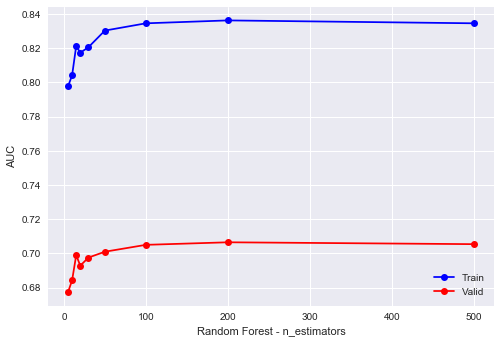

In [494]:
plt.plot(Cs, train_aucs,'bo-', label ='Train')
plt.plot(Cs, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Random Forest - n_estimators')
plt.ylabel('AUC')
plt.show()